<a href="https://colab.research.google.com/github/R12942159/NTU_ML/blob/Hw3/Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
import glob
import csv
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn

from PIL import Image
from torch.optim import Adam
from torchvision import transforms as tr
from torch.utils.data import DataLoader, Dataset, random_split

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ml2023-fall-hw3
!unzip 'ml2023-fall-hw3.zip'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Build Dataset

In [11]:
class Hw3_dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform, augmentation=True) -> None:
        self.all_data = np.load(data_path)
        self.transform = transform
        self.augmentation = augmentation

        hflip = tr.RandomHorizontalFlip(p=0.5)
        vflip = tr.RandomVerticalFlip(p=0.5)
        rotate = tr.RandomRotation(degrees=15)
        color = tr.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)

        def origine(x): return x
        if augmentation:
            self.augmentation = [hflip, vflip, rotate, origine]
        else:
            self.augmentation = [origine]

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        # read img
        img = self.all_data[idx]
        img /= 255.

        # transform/normalize img
        img = self.transform(img)

        # augmentation img
        augment = random.choice(self.augmentation)
        img = augment(img)
        return img

In [12]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

img_ds = Hw3_dataset(
    '/content/data/trainX.npy',
    transform = tr.Compose([
        tr.ToTensor(),
        tr.Normalize(mean=mean, std=std),
    ]),
    augmentation = True,
)

##### Randomly divided into a training and validation dataset.

In [15]:
train_prob = 0.85

train_size = int(len(img_ds) * train_prob)
val_size = int(len(img_ds) - train_size)
train_ds, val_ds = random_split(img_ds, [train_size, val_size])

##### Build Dataloders

In [ ]:
BATCH_SIZE = 128

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle=False, num_workers=4)

#### Contruct Model

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super(ConvBlock, self).__init__()

        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.05),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.05),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.05),
        )

    def __call__(self, x):
        return self.convblock(x)

class CNN_scratch(nn.Module):
    def __init__(self, num_classes=7, in_channels=3, init_channels=64, size=IMG_SIZE) -> None:
        super(CNN_scratch, self).__init__()

        # conv
        self.encoder1 = ConvBlock(in_channels, init_channels) # (3, H, W) -> (32, H, W)
        self.pooling1 = nn.MaxPool2d(2)
        self.encoder2 = ConvBlock(init_channels, init_channels * 2) # (32, H/2, W/2) -> (64, H/2, W/2)
        self.pooling2 = nn.MaxPool2d(2)
        self.encoder3 = ConvBlock(init_channels * 2, init_channels * 4) # (32, H/2, W/2) -> (64, H/2, W/2)
        self.pooling3 = nn.MaxPool2d(2)
        self.encoder4 = ConvBlock(init_channels * 4, init_channels * 8) # (32, H/2, W/2) -> (64, H/2, W/2)
        self.pooling4 = nn.MaxPool2d(2)
        self.encoder5 = ConvBlock(init_channels * 8, init_channels * 16) # (32, H/2, W/2) -> (64, H/2, W/2)
        self.pooling5 = nn.MaxPool2d(2)
        self.encoder6 = ConvBlock(init_channels * 16, init_channels * 32) # (64, H/2, W/2) -> (128, H/2, W/2)

        self.classifier = nn.Sequential(
            ConvBlock(init_channels * 32, num_classes, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )

    def forward(self, x):
        x = self.encoder1(x)
        x = self.encoder2(self.pooling1(x))
        x = self.encoder3(self.pooling2(x))
        x = self.encoder4(self.pooling3(x))
        x = self.encoder5(self.pooling4(x))
        x = self.encoder6(self.pooling5(x))
        x = self.classifier(x)
        x = torch.squeeze(x)

        return x

#### Build Model

In [ ]:
model = CNN_scratch().to(device)
print(model)

#### Model Summary

In [ ]:
from torchsummary import summary


summary(model, (3, IMG_SIZE, IMG_SIZE))

#### Define training and testing process

In [ ]:
from tqdm.auto import tqdm # (optional) progress bar


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 假設有7個類別，並且class1的樣本數較低
class_weights = compute_class_weight('balanced', classes=np.unique(img_labels), y=img_labels)
class_weights = torch.Tensor(class_weights)

In [ ]:
EPOCHS = 100

loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

# early stopping
patience = 10
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {(epoch+1):04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), f'DL_hw2_epoch{epoch+1}_model.pth')
    # chcek improvement
    if val_loss <  best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), 'DL_hw2_best_model.pth')
        torch.save(model.state_dict(), '/content/drive/MyDrive/NTU_ML/Hw2/best_model.pth')
        # torch.save(optimizer.state_dict(), 'DL_hw2_best_optimizer.pth')
        print('-------------------- Model Save --------------------')
    else:
        counter += 1
    if counter >= patience:
        print('-------------------- Early Stopping --------------------')
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 1.8759, train_acc: 0.195     val_loss: 1.7962, val_acc: 0.278 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 1.7757, train_acc: 0.247     val_loss: 1.8177, val_acc: 0.226 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 1.7404, train_acc: 0.266     val_loss: 1.7844, val_acc: 0.250 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 1.6918, train_acc: 0.305     val_loss: 1.7454, val_acc: 0.317 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 1.6490, train_acc: 0.341     val_loss: 1.7972, val_acc: 0.309 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 1.5804, train_acc: 0.390     val_loss: 1.6149, val_acc: 0.386 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 1.5035, train_acc: 0.419     val_loss: 1.6294, val_acc: 0.368 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 1.4770, train_acc: 0.434     val_loss: 1.5142, val_acc: 0.447 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 1.4088, train_acc: 0.467     val_loss: 1.4774, val_acc: 0.448 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 1.3759, train_acc: 0.479     val_loss: 1.5444, val_acc: 0.393 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 1.3307, train_acc: 0.498     val_loss: 1.4305, val_acc: 0.479 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 1.3068, train_acc: 0.506     val_loss: 1.3907, val_acc: 0.470 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 1.2629, train_acc: 0.523     val_loss: 1.4003, val_acc: 0.489 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 1.2511, train_acc: 0.528     val_loss: 1.3259, val_acc: 0.525 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 1.2049, train_acc: 0.544     val_loss: 1.3704, val_acc: 0.506 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 1.1954, train_acc: 0.549     val_loss: 1.3463, val_acc: 0.511 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 1.1632, train_acc: 0.558     val_loss: 1.3885, val_acc: 0.510 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0018     train_loss: 1.1241, train_acc: 0.575     val_loss: 1.3119, val_acc: 0.523 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0019     train_loss: 1.1381, train_acc: 0.567     val_loss: 1.2837, val_acc: 0.542 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0020     train_loss: 1.0920, train_acc: 0.590     val_loss: 1.2661, val_acc: 0.535 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0021     train_loss: 1.0775, train_acc: 0.596     val_loss: 1.3261, val_acc: 0.540 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0022     train_loss: 1.0438, train_acc: 0.609     val_loss: 1.2763, val_acc: 0.536 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0023     train_loss: 1.0131, train_acc: 0.622     val_loss: 1.2427, val_acc: 0.576 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0024     train_loss: 1.0050, train_acc: 0.625     val_loss: 1.2699, val_acc: 0.556 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0025     train_loss: 0.9765, train_acc: 0.636     val_loss: 1.2419, val_acc: 0.578 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0026     train_loss: 0.9559, train_acc: 0.645     val_loss: 1.2878, val_acc: 0.549 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0027     train_loss: 0.9437, train_acc: 0.647     val_loss: 1.2348, val_acc: 0.581 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0028     train_loss: 0.9020, train_acc: 0.669     val_loss: 1.2984, val_acc: 0.570 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0029     train_loss: 0.8947, train_acc: 0.670     val_loss: 1.3867, val_acc: 0.506 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0030     train_loss: 0.8801, train_acc: 0.678     val_loss: 1.1691, val_acc: 0.582 
-------------------- Model Save --------------------


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0031     train_loss: 0.8365, train_acc: 0.699     val_loss: 1.2056, val_acc: 0.588 


  0%|          | 0/199 [00:00<?, ?it/s]

EPOCH: 0032     train_loss: 0.8258, train_acc: 0.704     val_loss: 1.2346, val_acc: 0.571 


  0%|          | 0/199 [00:00<?, ?it/s]

#### plot loss/acc curve

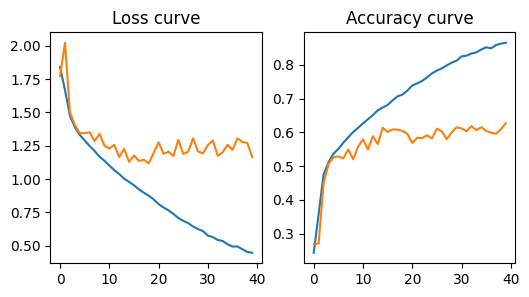

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title('Loss curve')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.savefig(os.path.join("/content/drive/MyDrive/NTU_ML/Hw2/loss"), format='png')

plt.subplot(1, 2, 2)
plt.title('Accuracy curve')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.savefig(os.path.join("/content/drive/MyDrive/NTU_ML/Hw2/acc"), format='png')

In [ ]:
def test(test_loader, model, file_name='predict.csv'):
    with torch.no_grad():
        predict_result = []
        predict_name = []
        for img, name in test_loader:
            img = img.to(device)
            pred = model(img)
            predict = torch.argmax(pred, dim=-1).tolist()
            predict_result += predict
            predict_name += name

    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in zip(predict_name, predict_result):
            writer.writerow([id, r])

In [ ]:
del model
model = CNN_scratch()
model.load_state_dict(torch.load('DL_hw2_best_model.pth'))
model = model.to(device)
test(test_loader, model)